# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

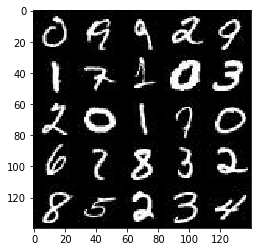

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

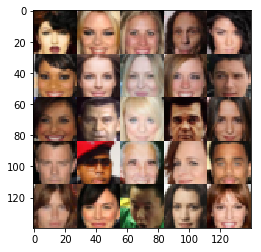

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units=128
    #ADDED BY REVIEW
    alpha = 0.10
    dropout_rate = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        print("images.get_shape()",images.get_shape())
        
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #Added By Review
        x1 = tf.layers.dropout(inputs=x1, rate=dropout_rate,training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        
        bn2 = tf.layers.dropout(inputs=bn2, rate=dropout_rate, training=True)
        
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        
        bn3 = tf.layers.dropout(inputs=bn3, rate=dropout_rate, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x128
        
        x4 = tf.layers.conv2d(relu3, 256, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        
        bn4 = tf.layers.dropout(inputs=bn4, rate=dropout_rate, training=True)
        
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits 
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

images.get_shape() (?, 28, 28, 3)
images.get_shape() (?, 28, 28, 3)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    n_units=128
    alpha = 0.10
    dropout_rate = 0.2    
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training= is_train)
        #ADDED BY REVIEW
        #x1 = tf.layers.dropout(inputs=x1, rate=dropout_rate, training= is_train)
        
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        #SUGGESTED 256= 2x128
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        #ADDED BY REVIEW
        x2 = tf.layers.dropout(inputs=x2, rate=dropout_rate, training= is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        #SUGGESTED 128= 2x64
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        #ADDED BY REVIEW
        x3 = tf.layers.dropout(inputs=x3, rate=dropout_rate, training= is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        #SUGGESTED 128= 2x64
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x4 = tf.layers.batch_normalization(x4, training= is_train)
        #ADDED BY REVIEW
        x4 = tf.layers.dropout(inputs=x4, rate=dropout_rate, training= is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x32 now
        
        # Output layer
        print("out_channel_dim",out_channel_dim)
        #ADDED BY REVIEW
        #x3 = tf.layers.dropout(inputs=x1, rate=dropout_rate, training= is_train)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim,3, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #ADDED BY REVIEW
        #logits = tf.layers.batch_normalization(logits, training= is_train)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

out_channel_dim 5
out_channel_dim 5
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #alpha = 0.01
    # ADDED BY REVIEW Smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
   
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real)*(1 - smooth))))
  
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
   
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

out_channel_dim 4
images.get_shape() (?, 28, 28, 4)
images.get_shape() (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print ("data_shape ",data_shape)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    print_every=10
    show_every=100
    samples, losses = [], []
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # ?????
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z})
                #ADDED BY REVIEW: 2 times generator optimization
               # _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format( epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                #if steps % show_every == 0:
                #    gen_samples = sess.run(
                       
                #                   generator(input_z, data_shape[3], is_train=False),
                #                   feed_dict={input_z: sample_z})
                #    samples.append(gen_samples)
                #    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                #    plt.show()
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

   
    
             

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

mnist_dataset.shape:  (60000, 28, 28, 1)
data_shape  (60000, 28, 28, 1)
out_channel_dim 1
images.get_shape() (?, 28, 28, 1)
images.get_shape() (?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 2.3905
Epoch 1/2... Discriminator Loss: 0.4484... Generator Loss: 2.8428
Epoch 1/2... Discriminator Loss: 0.3933... Generator Loss: 3.7484
Epoch 1/2... Discriminator Loss: 0.4073... Generator Loss: 3.4724
Epoch 1/2... Discriminator Loss: 0.4375... Generator Loss: 3.3326
Epoch 1/2... Discriminator Loss: 0.6896... Generator Loss: 1.6236
Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 1.5148
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 1.1776
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 1.5168
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.2242
out_channel_dim 1


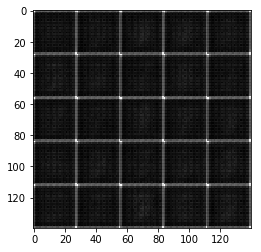

Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 2.1195
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 1.4390
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 1.5078
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 0.8699
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 1.4193
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 1.2194
out_channel_dim 1


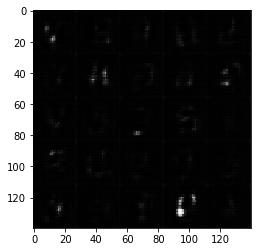

Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 1.3358
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 1.2938
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 1.2750
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 1.8056
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 1.3663
out_channel_dim 1


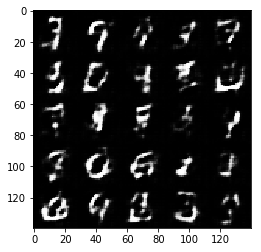

Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 1.0495
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 1.4525
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 1.1485
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.6450
Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.8194
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 1.3047
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 1.5297
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 1.0310
out_channel_dim 1


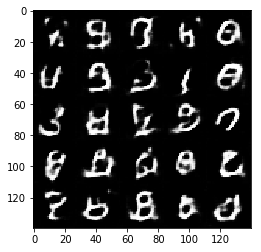

Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 1.0284
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 1.2014
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 1.1176
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.7600
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.9239
Epoch 2/2... Discriminator Loss: 1.3349... Generator Loss: 1.1504
Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 1.0324
out_channel_dim 1


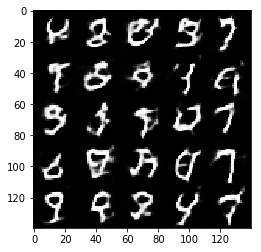

Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 1.4846
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.8210
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.9677
out_channel_dim 1


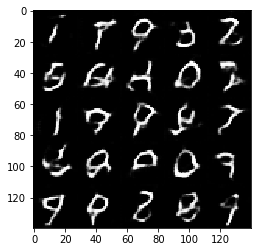

Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 1.4612
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.9436
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 0.9568
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.8621
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.7140
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.7889
out_channel_dim 1


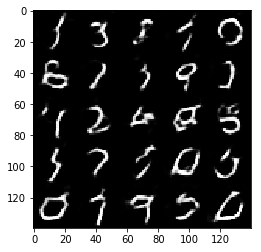

Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.8842
Epoch 2/2... Discriminator Loss: 1.4857... Generator Loss: 0.6913
Epoch 2/2... Discriminator Loss: 1.4750... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.4769... Generator Loss: 0.6372
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 1.0252
Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 1.4873... Generator Loss: 1.3087
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.9655
out_channel_dim 1


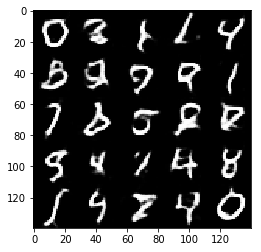

Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.6581
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.8334
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 1.4035... Generator Loss: 1.1488
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 1.0513
out_channel_dim 1


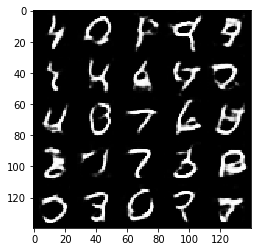

Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.7981
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.7939


In [12]:
#ADDED BY REVIEW (doubled)
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("mnist_dataset.shape: ", mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape  (202599, 28, 28, 3)
out_channel_dim 3
images.get_shape() (?, 28, 28, 3)
images.get_shape() (?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.6020
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.7644
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.7446
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.5219
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.3905
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.8431
out_channel_dim 3


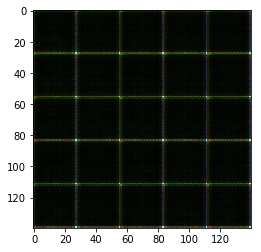

Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 2.1205
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 2.0511
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.6536
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.9170
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.8553
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 2.1770
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.6343
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.5182
out_channel_dim 3


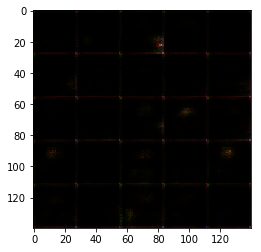

Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.6728
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.6061
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 2.0649
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 2.1584
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.7570
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.7026
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.9768
out_channel_dim 3


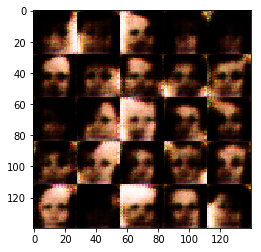

Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.7990
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 2.0237
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.4573
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 2.0576
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.8987
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 2.0154
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.9323
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 2.5172
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 2.2972
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 2.2622
out_channel_dim 3


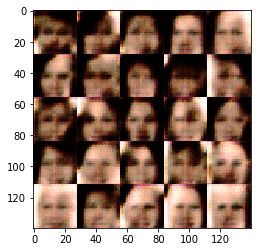

Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 2.0297
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 2.4430
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.6325
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.6611
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.8121
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 2.1518
Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 2.5359
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.7346
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 2.2693
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.5555
out_channel_dim 3


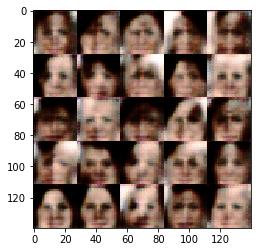

Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 2.1739
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.5622
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.5493
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.3865
out_channel_dim 3


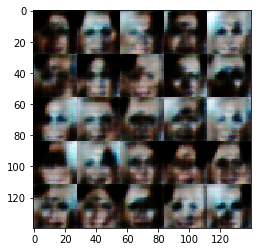

Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.5065
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.3839
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.3053
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.3864
out_channel_dim 3


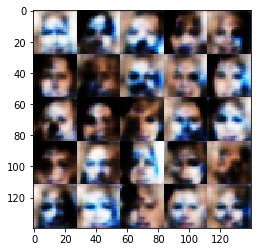

Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.1978
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.3158
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.1476
out_channel_dim 3


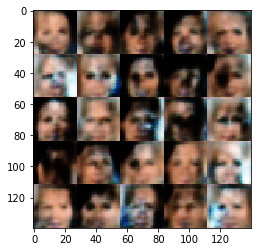

Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.3060
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.1256
out_channel_dim 3


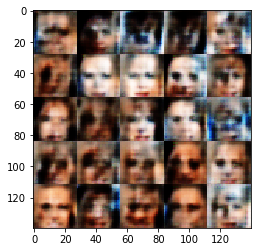

Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.0721
out_channel_dim 3


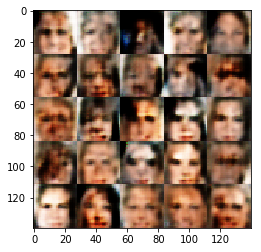

Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.8309
out_channel_dim 3


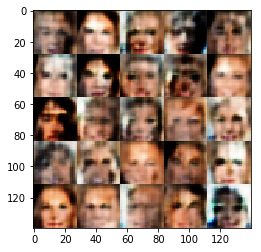

Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.1178
out_channel_dim 3


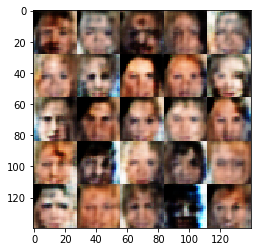

Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.9042
out_channel_dim 3


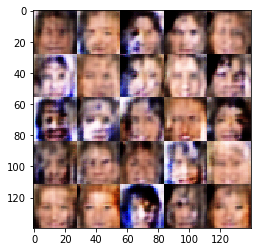

Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.0174
out_channel_dim 3


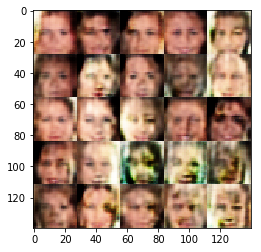

Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.1026
out_channel_dim 3


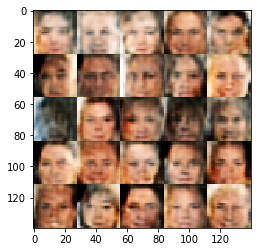

Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 1.0222
out_channel_dim 3


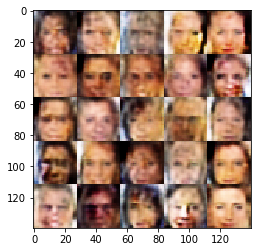

Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 1.0389
out_channel_dim 3


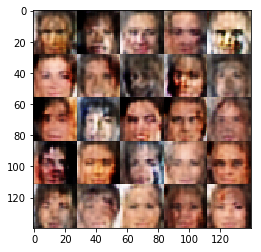

Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8816
out_channel_dim 3


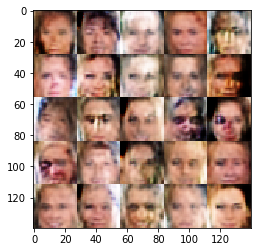

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.9502
out_channel_dim 3


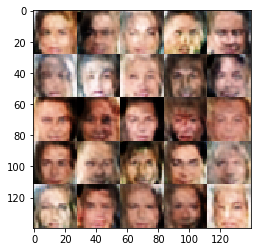

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.9346
out_channel_dim 3


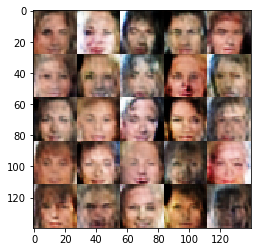

Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9877
out_channel_dim 3


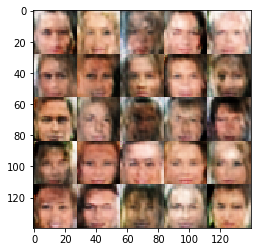

Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.9808
out_channel_dim 3


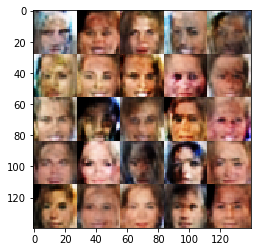

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.9218
out_channel_dim 3


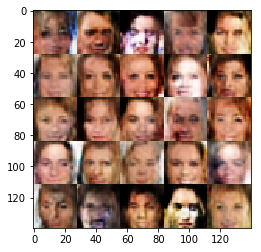

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.9042
out_channel_dim 3


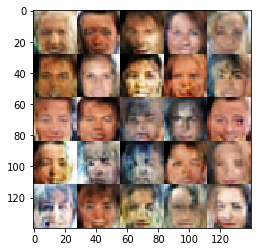

Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 1.0325
out_channel_dim 3


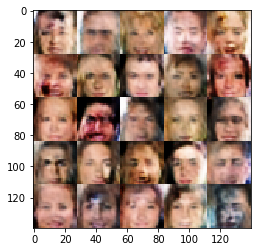

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8407
out_channel_dim 3


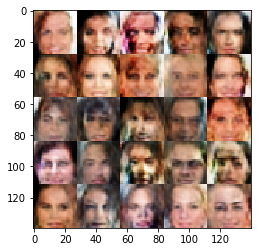

Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.9915
out_channel_dim 3


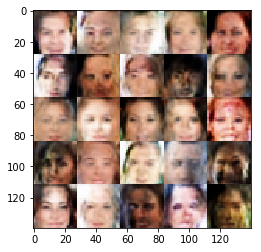

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.0066
out_channel_dim 3


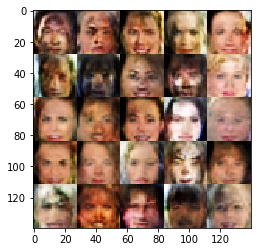

Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8748
out_channel_dim 3


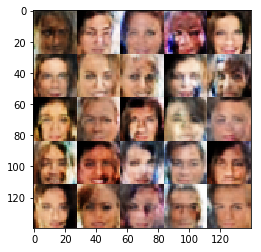

Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8862
out_channel_dim 3


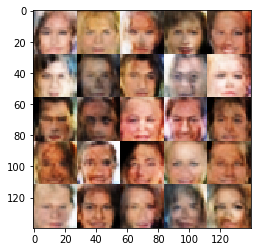

Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.8474
out_channel_dim 3


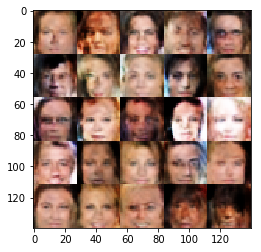

Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9489
out_channel_dim 3


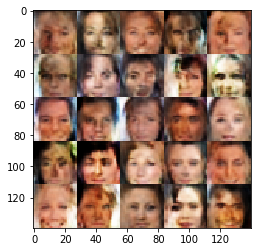

Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.8405
out_channel_dim 3


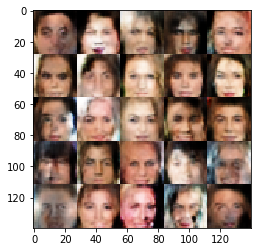

Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8733
out_channel_dim 3


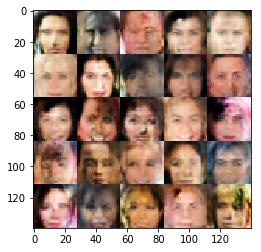

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7591
out_channel_dim 3


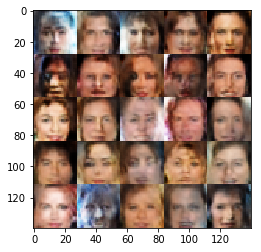

Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8246
out_channel_dim 3


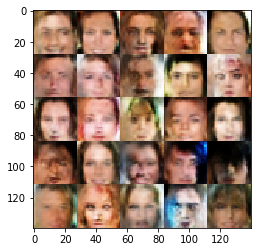

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7766
out_channel_dim 3


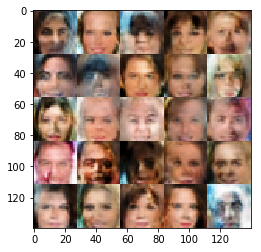

Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.9323
out_channel_dim 3


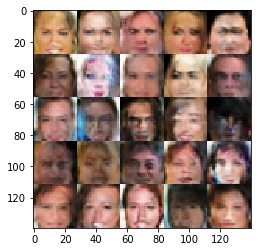

Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.8075
out_channel_dim 3


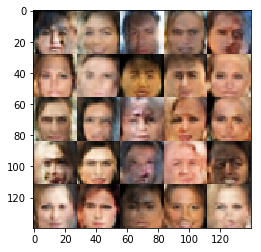

Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.9176
out_channel_dim 3


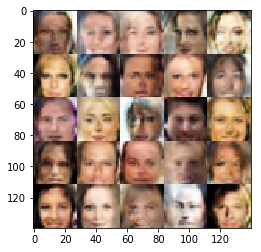

Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.8871
out_channel_dim 3


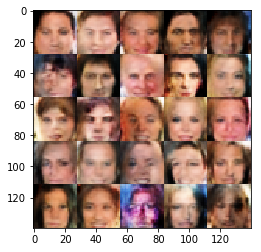

Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8549
out_channel_dim 3


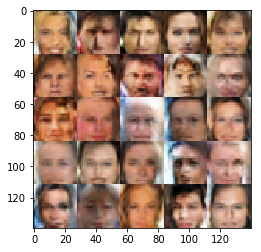

Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.9557
out_channel_dim 3


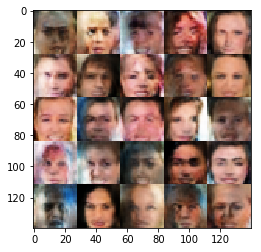

Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.9608
out_channel_dim 3


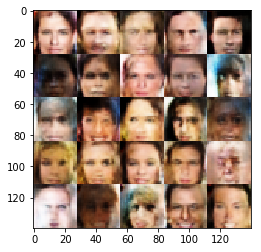

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8052
out_channel_dim 3


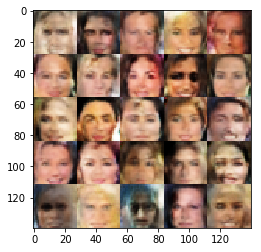

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8606
out_channel_dim 3


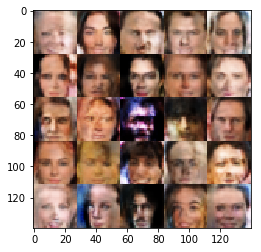

Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8580
out_channel_dim 3


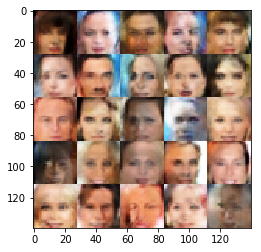

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7977
out_channel_dim 3


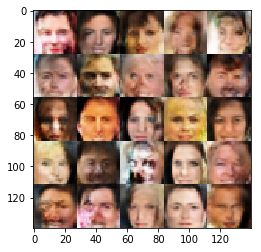

Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8445
out_channel_dim 3


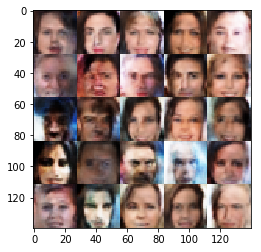

Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8613
out_channel_dim 3


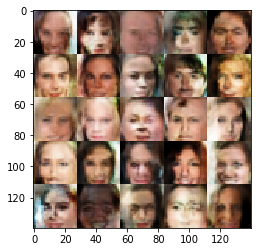

Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.9662
out_channel_dim 3


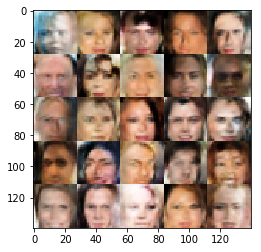

Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.8399
out_channel_dim 3


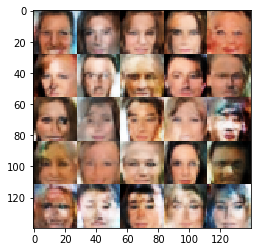

Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7668
out_channel_dim 3


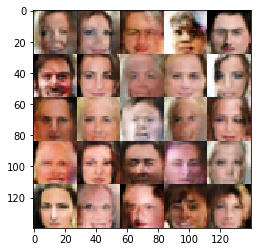

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8339
out_channel_dim 3


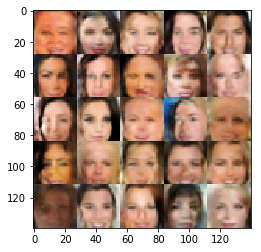

Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8466
out_channel_dim 3


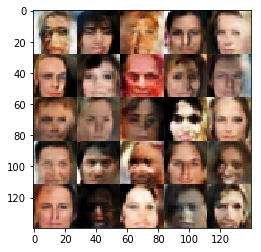

Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8091
out_channel_dim 3


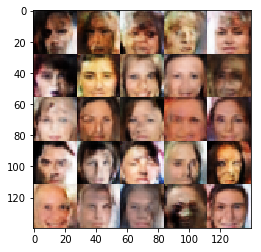

Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7630
out_channel_dim 3


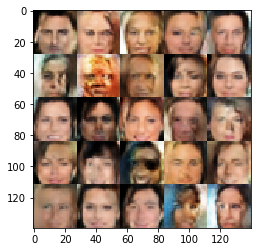

Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8288
out_channel_dim 3


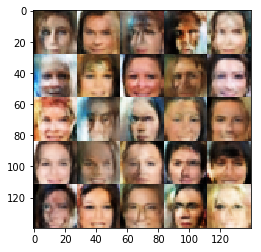

Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7923
out_channel_dim 3


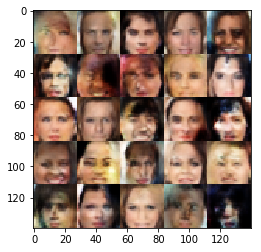

Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8017
out_channel_dim 3


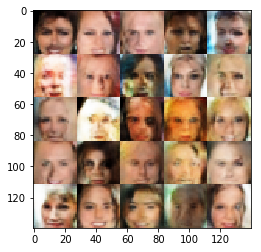

Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.8105
out_channel_dim 3


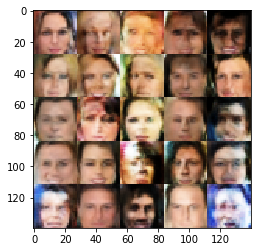

Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8184
out_channel_dim 3


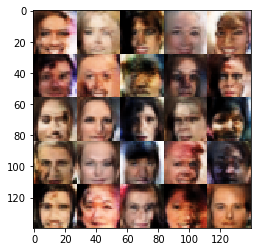

Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8434
out_channel_dim 3


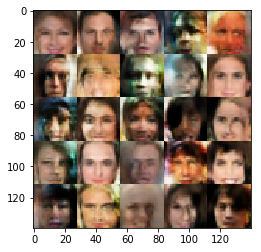

Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7687


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.